# Sensitivity of the Beam Factor to different choices

In this notebook, we look at the beam factor computed for the Nature Paper day 260,
in comparison to the beam factor computed by the legacy C-code, and explore what happens 
when we change some of the options. 

Note that there are datafiles used in this demo that are only accessible on a particular
cluster, so you will not be able to run it yourself. Nevertheless, it is still useful
for demonstrating how to use the `edges.sim` module.

In [13]:
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from edges import modelling as mdl

from edges.sim import beams, sky_models, compute_antenna_beam_factor
from edges import const

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
plt.style.use("dark_background")

In [4]:
alans_beam = beams.Beam.from_file(
    band="low",
    beam_file="/data4/nmahesh/edges/code_from_alan_org/newniv.txt",
    rotation_from_north=-6,
)
alan_beam_factor = np.genfromtxt(
    "/data4/nmahesh/edges/alans-pipeline/scripts/H2Case/beamcorr_626.txt"
)

### Fiducial Case

In [5]:
lst_list = np.arange(23.95244823089913, 35.7, 0.50441) % 24
assert len(lst_list) == 24

In [ ]:
const.KNOWN_T

In [15]:
defaults = dict(
    beam=alans_beam,
    f_low=40 * u.MHz,
    f_high=100 * u.MHz,
    lsts=lst_list,
    sky_model=sky_models.Haslam408AllNoh(),
    index_model=sky_models.ConstantIndex(),
    normalize_beam=False,
    reference_frequency=75 * u.MHz,
    beam_smoothing=False,
    interp_kind="nearest",
    freq_progress=False,
    location=const.KNOWN_TELESCOPES["edges-low-alan"].location,
    sky_at_reference_frequency=False,
    use_astropy_azel=False,
)

In [16]:
default = compute_antenna_beam_factor(**defaults)

24LST [00:42,  1.79s/LST]


In [18]:
use_astropy_azel = compute_antenna_beam_factor(**{**defaults, "use_astropy_azel": True})

0LST [00:00, ?LST/s]

24LST [00:51,  2.17s/LST]


In [19]:
sky_at_ref_freq = compute_antenna_beam_factor(
    **{**defaults, "sky_at_reference_frequency": True}
)

0LST [00:00, ?LST/s]

24LST [00:41,  1.74s/LST]


In [25]:
exact_location = compute_antenna_beam_factor(
    **{**defaults, "location": const.KNOWN_TELESCOPES["edges-low"].location}
)

0LST [00:00, ?LST/s]

24LST [00:42,  1.77s/LST]


In [26]:
linear_interp = compute_antenna_beam_factor(**{**defaults, "interp_kind": "linear"})

24LST [00:40,  1.70s/LST]


In [27]:
gauss_index = compute_antenna_beam_factor(
    **{**defaults, "index_model": sky_models.GaussianIndex()}
)

0LST [00:00, ?LST/s]

24LST [00:50,  2.10s/LST]


In [28]:
haslam_model = compute_antenna_beam_factor(
    **{**defaults, "sky_model": sky_models.Haslam408()}
)

24LST [04:47, 11.97s/LST]


In [29]:
lst_plus_5min = compute_antenna_beam_factor(**{**defaults, "lsts": lst_list + 5 / 60})

24LST [00:43,  1.79s/LST]


In [30]:
lst_minus_5min = compute_antenna_beam_factor(**{**defaults, "lsts": lst_list - 5 / 60})

0LST [00:00, ?LST/s]

24LST [00:44,  1.87s/LST]


In [31]:
fourier = mdl.Fourier(
    n_terms=31,
    transform=mdl.ShiftTransform(shift=75.0),
    period=1.2 * default.nfreq * (default.frequencies[1] - default.frequencies[0]),
)

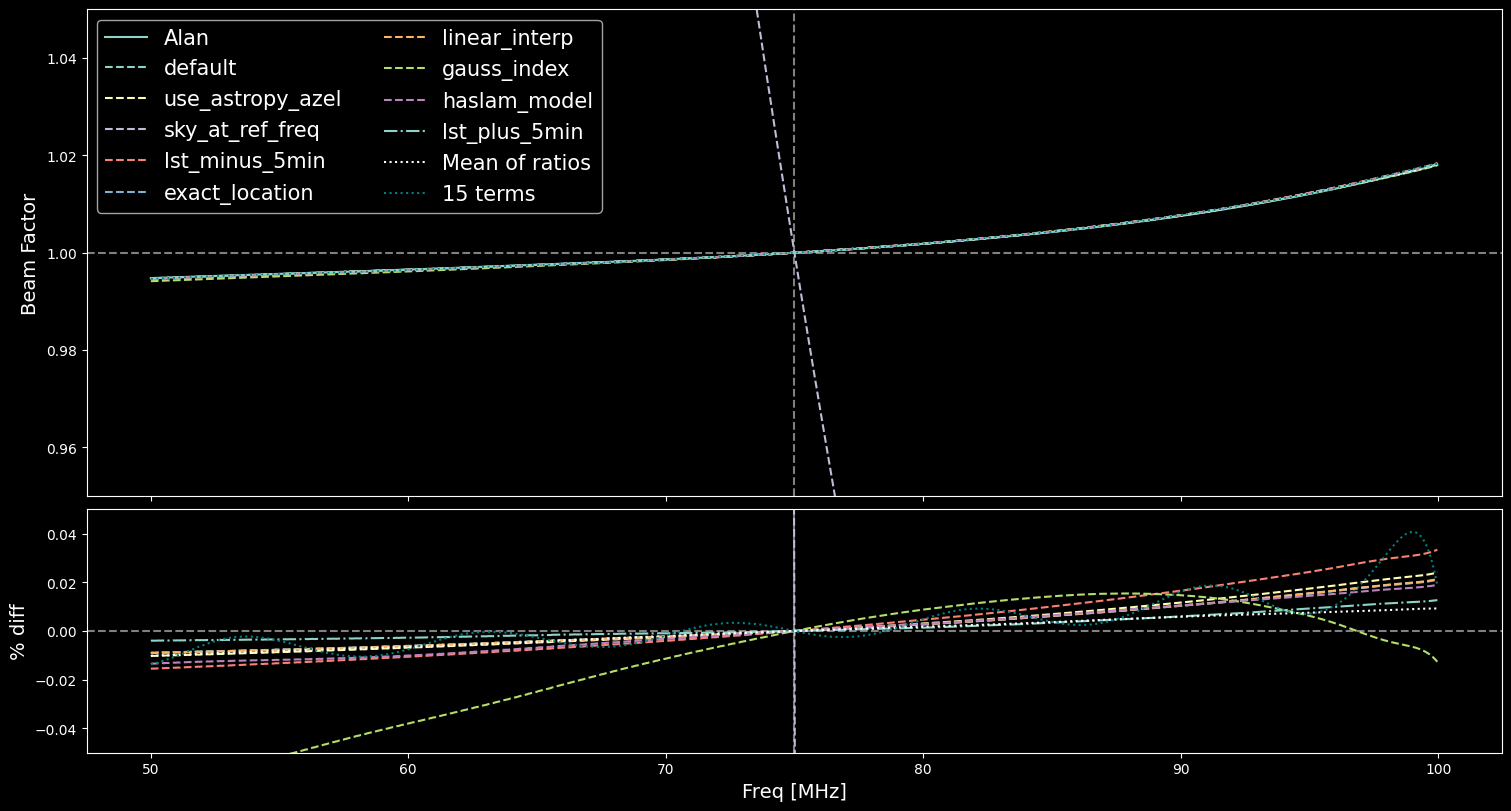

In [32]:
fig, ax = plt.subplots(
    2,
    1,
    sharex=True,
    constrained_layout=True,
    figsize=(15, 8),
    gridspec_kw={"height_ratios": (2, 1)},
)

ax[0].plot(alan_beam_factor[:, 0], 1 / alan_beam_factor[:, 3], label="Alan", ls="-")

ax[1].set_ylabel("% diff", fontsize=14)
ax[1].set_xlabel("Freq [MHz]", fontsize=14)
ax[0].axvline(75.0, ls="--", color="gray")
ax[1].axvline(75.0, ls="--", color="gray")
ax[0].axhline(1.0, ls="--", color="gray")
ax[1].axhline(0.0, ls="--", color="gray")
ax[0].set_ylabel("Beam Factor", fontsize=14)

try:
    del thing
except NameError:
    pass

stuff = {k: v for k, v in locals().items() if isinstance(v, beams.BeamFactor)}
for i, (name, thing) in enumerate(stuff.items()):
    integrated_beam_factor = thing.get_integrated_beam_factor(
        fourier, alan_beam_factor[:, 0]
    )
    style = dict(color=f"C{i % 8}", ls=["--", "-.", ":"][i // 8])
    ax[0].plot(alan_beam_factor[:, 0], integrated_beam_factor, label=name, **style)
    ax[1].plot(
        alan_beam_factor[:, 0],
        100 * (integrated_beam_factor * alan_beam_factor[:, 3] - 1),
        **style,
    )

# Also, evaluate the beam factor using mean of ratios...
beam_factor = default.get_mean_beam_factor(fourier, alan_beam_factor[:, 0])
ax[0].plot(
    alan_beam_factor[:, 0], beam_factor, label="Mean of ratios", color="white", ls=":"
)
ax[1].plot(
    alan_beam_factor[:, 0],
    100 * (beam_factor * alan_beam_factor[:, 3] - 1),
    color="white",
    ls=":",
)

# And use a different number of terms in the model...
fourier15 = mdl.Fourier(
    n_terms=15,
    transform=mdl.ShiftTransform(shift=75.0),
    period=1.2 * default.nfreq * (default.frequencies[1] - default.frequencies[0]),
)
beam_factor = default.get_integrated_beam_factor(fourier15, alan_beam_factor[:, 0])
ax[0].plot(alan_beam_factor[:, 0], beam_factor, label="15 terms", color="teal", ls=":")
ax[1].plot(
    alan_beam_factor[:, 0],
    100 * (beam_factor * alan_beam_factor[:, 3] - 1),
    color="teal",
    ls=":",
)

ax[0].plot()
ax[0].legend(fontsize=15, ncol=2)
ax[0].set_ylim(0.95, 1.05)
ax[1].set_ylim(-0.05, 0.05)
ax[0].grid(False)
ax[1].grid(False)